In [1]:
import pandas as pd
import numpy as np
import pickle as pk
import os
import glob
import zlib

# manually specify the GPUs to use
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"]="4"

#from stellargraph import StellarGraph
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold


In [2]:
# from PDG to label
def pdg2tos(pdg):
    if pdg==13 or pdg==-13 or pdg==211 or pdg==-211:
        return 0 # track
    if pdg==2212 or pdg==321 or pdg==-321:
        return 1 # heavy track
    if pdg==11 or pdg==-11 or pdg==22:
        return 2 # shower
    return -1

In [ ]:
## Data generation 

## SKIP THIS if you don't have the pickle files already processed

graph=0
total_nodes = 0
maxDist = 10.0
pdgs = []
labels = []



numGraphs = len(list(glob.iglob('/eos/user/a/aabedabu/physics_gnn/physics_processed_data_collection/prod4/grid_8000/mc_sce_dd/*/*.gz')))
for graph_path in glob.iglob('/eos/user/a/aabedabu/physics_gnn/physics_processed_data_collection/prod4/grid_8000/mc_sce_dd/*/*.gz'):
    if graph % 100 == 0:
        print(str(graph) + " out of " + str(numGraphs))
    with open(graph_path[:-3]+'.info', 'rb') as info_file:
        lines = info_file.readlines()
        values = {'X':float(lines[0]),
                  'Y':float(lines[1]),
                  'Z':float(lines[2]),
                  'Energy':float(lines[3]),
                  'Interaction':int(lines[4]),
                  'PDG':int(lines[5]),
                  'NumberOfNodes':int(lines[6]),
                  'NumberOfFeatures':int(lines[7])
                  }
        #print(values)
        
    nnodes = values['NumberOfNodes']
    
    # spatial coordinates
    XYZ=np.zeros(shape=(nnodes,3),dtype=float)
    
    # create feature dict on the first iteration
    if graph == 0:
        features = {}
        for j in range(3,3+values['NumberOfFeatures']):
            features['feature'+str(j-2)] = []
    
    # all nodes are usable by deafault
    usable = [True]*nnodes
        
    # iterate over nodes and save spatial coordinates
    with open(graph_path, 'rb') as graph_file:
        codes = np.fromstring(zlib.decompress(graph_file.read()), dtype=np.float32, sep='')
        for node_id in range(nnodes):
            label = pdg2tos(codes[node_id*(3+values['NumberOfFeatures']+1)+(3+values['NumberOfFeatures'])])
            if label == -1:
                usable[node_id] = False
                continue
            
            # coordinates
            X = codes[node_id*(3+values['NumberOfFeatures']+1)+0]
            Y = codes[node_id*(3+values['NumberOfFeatures']+1)+1]
            Z = codes[node_id*(3+values['NumberOfFeatures']+1)+2]
            XYZ[node_id,:]=[X, Y, Z]
            
    # iterate over nodes
    count=0
    with open(graph_path, 'rb') as graph_file:
        codes = np.fromstring(zlib.decompress(graph_file.read()), dtype=np.float32, sep='')
        for node_id in range(nnodes):
            if not usable[node_id]:
                continue
            
            # features
            for j in range(3,3+values['NumberOfFeatures']):
                features['feature'+str(j-2)].append(codes[node_id*(3+values['NumberOfFeatures']+1)+j])
                
            # PDG:
            pdgs.append(int(codes[node_id*(3+values['NumberOfFeatures']+1)+(3+values['NumberOfFeatures'])]))
            labels.append(label)
            
            #print(features, pdgs, labels)
               
    
    graph+=1
        
# pdgs and labels to np.array
pdgs = np.array(pdgs)
labels = np.array(labels)


    
# define nodes
nodes = pd.DataFrame(
    features
)

# dump dataset

## Dump everything
with open('dataset_nodes_pdgs_labels.p', 'wb') as fd:
    pk.dump([graph, pdgs, labels], fd)

## Dump only features    
pd.to_pickle(nodes, "./features.pkl")



In [3]:
## Data input

# load graph
with open('dataset_nodes_pdgs_labels.p', 'rb') as fd:
    graph, pdgs, labels = pk.load(fd)

    
labels=pd.Series(labels)
nodes = pd.read_pickle("./features.pkl")


    

In [4]:
## Create new labels

# Old labels        
# 0 = track
# 1 = heavy track
# 2 = shower
        
# New labels        
# 0 = track
# 1 = shower

track_number = 0
shower_number = 0
new_labels_list = []
for x in labels:
    if x<2:
        new_labels_list.append(0)
        track_number += 1
    else:
        new_labels_list.append(1)
        shower_number += 1

new_labels = pd.Series(new_labels_list) 
print("Total number of events: ", track_number+shower_number)
print("Total number of tracks: ", track_number)
print("Total number of showers: ", shower_number)
print("Ratio of tracks: ", track_number/(track_number+shower_number))
print("Ratio of showers: ", shower_number/(track_number+shower_number))

Total number of events:  7030533
Total number of tracks:  2315092
Total number of showers:  4715441
Ratio of tracks:  0.32929110780078835
Ratio of showers:  0.6707088921992116


In [5]:
## Look at the features

print(nodes.head())

   feature1  feature2  feature3   feature4  feature5  feature6  feature7  \
0      17.0      53.0     128.0  12.028289  0.048538  0.249053    1270.0   
1      18.0      54.0     128.0  32.379967 -0.017928  2.538584    1329.0   
2      19.0      54.0     128.0  39.963924 -0.009562  2.760196    1398.0   
3      19.0      54.0     128.0  29.785406 -0.011091  2.890076    1408.0   
4      20.0      54.0     128.0  69.445038 -0.019203  3.075611    1486.0   

   feature8  feature9  
0    4378.0   12097.0  
1    4439.0   12077.0  
2    4432.0   12070.0  
3    4442.0   12080.0  
4    4402.0   12040.0  


In [6]:
## Features:

# Feature1  neighbour_3
# Feature2  neighbour_10
# Feature3  neighbour_30
# Feature4  charge_map
# Feature5  dot_product
# Feature6  angle
# Feature7  charge_distance_3
# Feature8  charge_distance_10
# Feature9  charge_distance_30

# Rename and describe the data frame
nodes.columns = ["neighbour_3", "neighbour_10", "neighbour_30", "charge_map", "dot_product", "angle", "charge_distance_3", "charge_distance_10", "charge_distance_30"]

nodes.describe()

,neighbour_3,neighbour_10,neighbour_30,charge_map,dot_product,angle,charge_distance_3,charge_distance_10,charge_distance_30
count,7.030533e+06,7.030533e+06,7.030533e+06,7.030533e+06,7.030533e+06,7.030533e+06,7.030533e+06,7.030533e+06,7.030533e+06
mean,2.497649e+01,1.113293e+02,3.483956e+02,5.705963e+01,1.804495e-01,1.490602e+00,1.454060e+03,6.613205e+03,2.013232e+04
std,1.076896e+01,5.971821e+01,1.779324e+02,5.215720e+01,1.969706e+01,1.217663e+00,1.110965e+03,4.996266e+03,1.293129e+04
min,0.000000e+00,0.000000e+00,0.000000e+00,5.439834e-03,-2.123361e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.800000e+01,7.200000e+01,2.240000e+02,2.959888e+01,-2.227991e-02,1.451090e-01,8.710000e+02,3.419000e+03,1.068500e+04
50%,2.700000e+01,1.000000e+02,3.080000e+02,4.082213e+01,2.128416e-04,1.484194e+00,1.129000e+03,4.317000e+03,1.452500e+04
75%,3.100000e+01,1.330000e+02,4.510000e+02,6.654980e+01,2.362917e-02,2.857099e+00,1.755000e+03,8.651000e+03,2.895200e+04
max,1.350000e+02,5.320000e+02,1.754000e+03,3.050392e+03,2.849225e+04,3.141593e+00,1.888800e+04,4.613800e+04,1.101830e+05


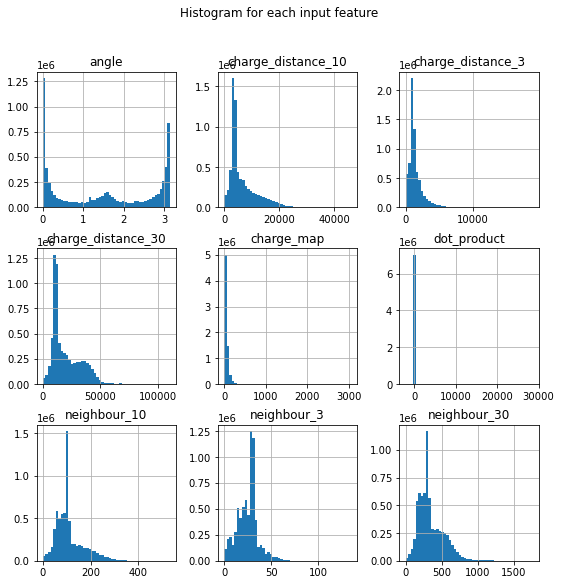

In [8]:
import pylab as plt
nodes.hist(bins=50, figsize=(9,9))
plt.suptitle("Histogram for each input feature")
plt.savefig('plots/ML_analysis_features')
plt.show()

In [9]:
## Split the data

from sklearn.model_selection import train_test_split

X = nodes
y = new_labels

#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size=0.6, test_size=None, shuffle=False)



In [10]:
## Preprocessing : scaling

#from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

#scaler = MinMaxScaler()
scaler = RobustScaler()
X = scaler.fit_transform(X)


In [11]:
## Logistic regression
from sklearn.linear_model import LogisticRegression

kfold = KFold(n_splits=10, random_state=7)

logreg = LogisticRegression(solver="liblinear")

result = cross_val_score(logreg, X, y, cv=kfold, scoring='accuracy')
print("%s: Mean Accuracy = %.2f%% - SD Accuracy = %.2f%%" % ("Linear regression", result.mean()*100, result.std()*100))

Linear regression: Mean Accuracy = 65.95% - SD Accuracy = 1.36%


In [12]:
## Decision tree

from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(criterion="entropy")

kfold = KFold(n_splits=10, random_state=7)


result = cross_val_score(clf, X, y, cv=kfold, scoring='accuracy')
print("%s: Mean Accuracy = %.2f%% - SD Accuracy = %.2f%%" % ("Decision Tree", result.mean()*100, result.std()*100))

Decision Tree: Mean Accuracy = 68.62% - SD Accuracy = 0.71%


In [13]:
## K-Nearest Neighbors

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5, metric="minkowski",p=2)


kfold = KFold(n_splits=10, random_state=7)


result = cross_val_score(knn, X, y, cv=kfold, scoring='accuracy')
print("%s: Mean Accuracy = %.2f%% - SD Accuracy = %.2f%%" % ("K Nearest Neighbor", result.mean()*100, result.std()*100))

K Nearest Neighbor: Mean Accuracy = 71.45% - SD Accuracy = 0.89%


In [14]:
## Linear Discriminant Analysis

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()



kfold = KFold(n_splits=10, random_state=7)


result = cross_val_score(lda, X, y, cv=kfold, scoring='accuracy')
print("%s: Mean Accuracy = %.2f%% - SD Accuracy = %.2f%%" % ("Linear Discriminant Analysis", result.mean()*100, result.std()*100))

Linear Discriminant Analysis: Mean Accuracy = 65.87% - SD Accuracy = 1.57%


In [15]:
## Gaussian Naive Bayes

from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()


kfold = KFold(n_splits=10, random_state=7)


result = cross_val_score(gnb, X, y, cv=kfold, scoring='accuracy')
print("%s: Mean Accuracy = %.2f%% - SD Accuracy = %.2f%%" % ("Gaussian Naive Bayes", result.mean()*100, result.std()*100))

Gaussian Naive Bayes: Mean Accuracy = 63.78% - SD Accuracy = 1.58%


In [16]:
## Random Forest

from sklearn.ensemble import RandomForestClassifier


random_forest_clf = RandomForestClassifier(n_estimators=100, criterion="entropy")


kfold = KFold(n_splits=10, random_state=7)


result = cross_val_score(random_forest_clf, X, y, cv=kfold, scoring='accuracy')
print("%s: Mean Accuracy = %.2f%% - SD Accuracy = %.2f%%" % ("Random Forest", result.mean()*100, result.std()*100))

Random Forest: Mean Accuracy = 72.90% - SD Accuracy = 1.01%


In [ ]:
## SVC

from sklearn.ensemble import RandomForestClassifier


random_forest_clf = RandomForestClassifier(n_estimators=100, criterion="entropy")


kfold = KFold(n_splits=10, random_state=7)


result = cross_val_score(random_forest_clf, X, y, cv=kfold, scoring='accuracy')
print("%s: Mean Accuracy = %.2f%% - SD Accuracy = %.2f%%" % ("Random Forest", result.mean()*100, result.std()*100))